## M06 Homework

### Michael Vaden, mtv2eva

In [223]:
import pandas as pd
import numpy as np
from glob import glob
import re
import nltk
import plotly_express as px
from lib.textparser import TextParser
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

from numpy.linalg import norm
from scipy.spatial.distance import pdist
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

In [194]:
import configparser
config = configparser.ConfigParser()
config.read("../env.ini")
data_home = config['DEFAULT']['data_home']
output_dir = config['DEFAULT']['output_dir']
data_prefix = 'austen-melville'

In [195]:
OHCO = ['book_id', 'chap_id', 'para_num', 'sent_num', 'token_num']
bags = dict(
    SENTS = OHCO[:4],
    PARAS = OHCO[:3],
    CHAPS = OHCO[:2],
    BOOKS = OHCO[:1]
)

In [196]:
LIB = pd.read_csv(f"{output_dir}/{data_prefix}-LIB.csv").set_index('book_id')
CORPUS = pd.read_csv(f"{output_dir}/{data_prefix}-CORPUS.csv").set_index(OHCO)
VOCAB = pd.read_csv(f'{output_dir}/{data_prefix}-VOCAB.csv').set_index('term_str').dropna()

In [197]:
austen_dates = {
    "EMMA": 1815,
    "LADY SUSAN": 1794,
    "LOVE AND FREINDSHIP SIC": 1790,
    "MANSFIELD PARK": 1814,
    "NORTHANGER ABBEY": 1803,
    "PERSUASION": 1818,
    "PRIDE AND PREJUDICE": 1813,
    "SENSE AND SENSIBILITY": 1811
}

LIB['year'] = LIB['title'].map(austen_dates)
LIB['label'] = LIB['year'].astype(str) + '_' + LIB['title']
LIB = LIB.query("author == 'AUSTEN, JANE'")

LIB

,source_file_path,author,title,chap_regex,book_len,n_chaps,year,label
book_id,,,,,,,,
105,/Users/michaelvaden/GithubRepos/DS5001-Workpla...,"AUSTEN, JANE",PERSUASION,^Chapter\s+\d+$,83624,24,1818.0,1818.0_PERSUASION
121,/Users/michaelvaden/GithubRepos/DS5001-Workpla...,"AUSTEN, JANE",NORTHANGER ABBEY,^CHAPTER\s+\d+$,77601,31,1803.0,1803.0_NORTHANGER ABBEY
141,/Users/michaelvaden/GithubRepos/DS5001-Workpla...,"AUSTEN, JANE",MANSFIELD PARK,^CHAPTER\s+[IVXLCM]+$,160378,48,1814.0,1814.0_MANSFIELD PARK
158,/Users/michaelvaden/GithubRepos/DS5001-Workpla...,"AUSTEN, JANE",EMMA,^\s*CHAPTER\s+[IVXLCM]+\s*$,160926,55,1815.0,1815.0_EMMA
161,/Users/michaelvaden/GithubRepos/DS5001-Workpla...,"AUSTEN, JANE",SENSE AND SENSIBILITY,^CHAPTER\s+\d+$,119873,50,1811.0,1811.0_SENSE AND SENSIBILITY
946,/Users/michaelvaden/GithubRepos/DS5001-Workpla...,"AUSTEN, JANE",LADY SUSAN,^\s*[IVXLCM]+\s*$,23116,41,1794.0,1794.0_LADY SUSAN
1212,/Users/michaelvaden/GithubRepos/DS5001-Workpla...,"AUSTEN, JANE",LOVE AND FREINDSHIP SIC,^\s*LETTER .* to .*$,33265,24,1790.0,1790.0_LOVE AND FREINDSHIP SIC
1342,/Users/michaelvaden/GithubRepos/DS5001-Workpla...,"AUSTEN, JANE",PRIDE AND PREJUDICE,^Chapter\s+\d+$,122126,61,1813.0,1813.0_PRIDE AND PREJUDICE


In [198]:
def create_bag_of_words(CORPUS, bag):
    BOW = CORPUS.groupby(bag+['term_str']).term_str.count().to_frame('n')
    return BOW

idf_method = 'standard' 

def get_TFIDF(BOW, tf_method):
    DTCM = BOW.n.unstack(fill_value=0)

    DF = DTCM.astype('bool').sum() 
    N = len(DTCM)

    if tf_method == 'sum':
        TF = DTCM.T / DTCM.T.sum()

    elif tf_method == 'max':
        TF = DTCM.T / DTCM.T.max()
        
    elif tf_method == 'log':
        TF = np.log2(1 + DTCM.T)
        
    elif tf_method == 'raw':
        TF = DTCM.T
        
    elif tf_method == 'double_norm':
        TF = DTCM.T / DTCM.T.max()
        
    elif tf_method == 'binary':
        TF = DTCM.T.astype('bool').astype('int')
    
    TF = TF.T

    if idf_method == 'standard':
        IDF = np.log2(N / DF)

    elif idf_method == 'max':
        IDF = np.log2(DF.max() / DF) 

    elif idf_method == 'smooth':
        IDF = np.log2((1 + N) / (1 + DF)) + 1

    return TF * IDF, DF * IDF

In [199]:
CORPUS = CORPUS.loc[LIB.index]

In [201]:
TFIDF = get_TFIDF(create_bag_of_words(CORPUS, bags['CHAPS']), 'max')[0]

TFIDF

term_str           0         1   10  10000  10th  11th   12  12th  1399  13th  \
book_id chap_id                                                                 
105     1        0.0  0.119092  0.0    0.0   0.0   0.0  0.0   0.0   0.0   0.0   
        2        0.0  0.000000  0.0    0.0   0.0   0.0  0.0   0.0   0.0   0.0   
        3        0.0  0.000000  0.0    0.0   0.0   0.0  0.0   0.0   0.0   0.0   
        4        0.0  0.000000  0.0    0.0   0.0   0.0  0.0   0.0   0.0   0.0   
        5        0.0  0.000000  0.0    0.0   0.0   0.0  0.0   0.0   0.0   0.0   
...              ...       ...  ...    ...   ...   ...  ...   ...   ...   ...   
1342    57       0.0  0.000000  0.0    0.0   0.0   0.0  0.0   0.0   0.0   0.0   
        58       0.0  0.000000  0.0    0.0   0.0   0.0  0.0   0.0   0.0   0.0   
        59       0.0  0.000000  0.0    0.0   0.0   0.0  0.0   0.0   0.0   0.0   
        60       0.0  0.000000  0.0    0.0   0.0   0.0  0.0   0.0   0.0   0.0   
        61       0.0  0.000000  0.0    0.0   0.0   0.0  0.0   0.0   0.0   0.0   

term_str         ...  youthful  youths  yrs         z      zeal   zealous  \
book_id chap_id  ...                                                        
105     1        ...  0.043417     0.0  0.0  0.067611  0.000000  0.000000   
        2        ...  0.000000     0.0  0.0  0.000000  0.000000  0.061689   
        3        ...  0.000000     0.0  0.0  0.000000  0.036998  0.000000   
        4        ...  0.000000     0.0  0.0  0.000000  0.000000  0.000000   
        5        ...  0.000000     0.0  0.0  0.000000  0.000000  0.000000   
...              ...       ...     ...  ...       ...       ...       ...   
1342    57       ...  0.000000     0.0  0.0  0.000000  0.000000  0.000000   
        58       ...  0.000000     0.0  0.0  0.000000  0.000000  0.000000   
        59       ...  0.000000     0.0  0.0  0.000000  0.000000  0.000000   
        60       ...  0.000000     0.0  0.0  0.000000  0.000000  0.000000   
        61       ...  0.000000     0.0  0.0  0.000000  0.000000  0.000000   

term_str         zealously  zephyr  zigzags  ł20000  
book_id chap_id                                      
105     1              0.0     0.0      0.0     0.0  
        2              0.0     0.0      0.0     0.0  
        3              0.0     0.0      0.0     0.0  
        4              0.0     0.0      0.0     0.0  
        5              0.0     0.0      0.0     0.0  
...                    ...     ...      ...     ...  
1342    57             0.0     0.0      0.0     0.0  
        58             0.0     0.0      0.0     0.0  
        59             0.0     0.0      0.0     0.0  
        60             0.0     0.0      0.0     0.0  
        61             0.0     0.0      0.0     0.0  

[334 rows x 14745 columns]

In [202]:
DFIDF = get_TFIDF(create_bag_of_words(CORPUS, bags['CHAPS']), 'max')[1].to_frame('DFIDF')

DFIDF

,DFIDF
term_str,
0,8.383704
1,14.767409
10,20.396225
10000,8.383704
10th,14.767409
...,...
zealous,34.792451
zealously,14.767409
zephyr,8.383704


In [203]:
part_of_speech = ['NN', 'NNS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'JJ', 'JJR', 'JJS', 'RB', 'RBR', 'RBS']

Collapsed_TFIDF = TFIDF.loc[:, VOCAB.query("max_pos in @part_of_speech").join(DFIDF).sort_values('DFIDF', ascending=False)\
          .head(1000).reset_index()['term_str'].to_list()].reset_index().groupby(['book_id']).mean().drop('chap_id', axis=1)

Collapsed_TFIDF

term_str,respect,forward,greatest,stay,thinking,assure,marriage,fortune,believed,new,...,impression,unable,deep,sensations,forth,tired,number,inconvenience,habits,fall
book_id,,,,,,,,,,,,,,,,,,,,,
105,0.006140,0.009262,0.003233,0.010584,0.011340,0.010205,0.011468,0.013589,0.008962,0.010591,...,0.006734,0.004557,0.004729,0.007360,0.002720,0.006822,0.008072,0.004510,0.006116,0.006962
121,0.004111,0.006748,0.007326,0.008810,0.008241,0.008954,0.005660,0.010054,0.009190,0.016896,...,0.002037,0.001299,0.006226,0.002145,0.010879,0.015114,0.008718,0.001490,0.002851,0.002954
141,0.009049,0.009500,0.010356,0.009412,0.010821,0.004308,0.007412,0.006946,0.008376,0.009582,...,0.006074,0.003468,0.005070,0.007835,0.002607,0.006576,0.004042,0.006282,0.009751,0.004818
158,0.011402,0.008882,0.007157,0.011392,0.014596,0.014604,0.009475,0.010334,0.011059,0.009415,...,0.003549,0.000696,0.006773,0.006615,0.002374,0.009169,0.004511,0.004739,0.006200,0.004787
161,0.006497,0.006474,0.009488,0.008128,0.005347,0.009847,0.013288,0.012934,0.008158,0.010615,...,0.003638,0.011270,0.002284,0.001596,0.007869,0.003723,0.005238,0.009412,0.001201,0.003044
946,0.010156,0.010188,0.015570,0.005638,0.001255,0.005513,0.021950,0.005375,0.009788,0.000000,...,0.004818,0.001120,0.001906,0.005358,0.010269,0.003918,0.000000,0.000000,0.000000,0.000000
1212,0.003126,0.001501,0.010051,0.000884,0.003517,0.011138,0.016403,0.011411,0.000000,0.005096,...,0.010533,0.002869,0.000339,0.002735,0.004974,0.003257,0.002193,0.000339,0.000000,0.004184
1342,0.009518,0.006757,0.005553,0.012313,0.007312,0.013715,0.020465,0.014328,0.010656,0.007232,...,0.003633,0.008668,0.005856,0.001252,0.002502,0.001891,0.002116,0.003562,0.001980,0.005847


In [224]:
L0 = Collapsed_TFIDF.astype('bool').astype('int') # Binary (Pseudo L)
L1 = Collapsed_TFIDF.apply(lambda x: x / x.sum(), 1) # Probabilistic
L2 = Collapsed_TFIDF.apply(lambda x: x / norm(x), 1) # Pythagorean, AKA Euclidean

PAIRS = pd.DataFrame(index=pd.MultiIndex.from_product([LIB.index.tolist(), LIB.index.tolist()])).reset_index()

# Keep only unique pairs of different books
PAIRS = PAIRS[PAIRS.level_0 < PAIRS.level_1].set_index(['level_0','level_1'])

# Name index cols
PAIRS.index.names = ['doc_a', 'doc_b']

In [226]:
PAIRS['cityblock'] = pdist(Collapsed_TFIDF, 'cityblock')
PAIRS['euclidean'] = pdist(Collapsed_TFIDF, 'euclidean')
PAIRS['cosine'] = pdist(Collapsed_TFIDF, 'cosine')
PAIRS['jaccard'] = pdist(L0, 'jaccard')
PAIRS['dice'] = pdist(L0, 'dice')
PAIRS['js'] = pdist(L1, 'jensenshannon')  

In [241]:
def hac(sims, linkage_method='complete', color_thresh=.3, figsize=(10, 10)):

    # Generate the clustering
    tree = sch.linkage(sims, method=linkage_method)
    
    # Get labels for the leaves
    labels = LIB.label.values
    
    # Create a figure 
    plt.figure()
    fig, axes = plt.subplots(figsize=(figsize))
    
    # Create a dendrogram with the tree
    dendrogram = sch.dendrogram(tree, 
                                labels=labels, 
                                orientation="left", 
                                count_sort=True,
                                distance_sort=True,
                                above_threshold_color='.75',
                                color_threshold=color_thresh
                               )
    
    # Change the appearance of ticks, tick labels, and gridlines
    plt.tick_params(axis='both', which='major', labelsize=14)

<Figure size 640x480 with 0 Axes>

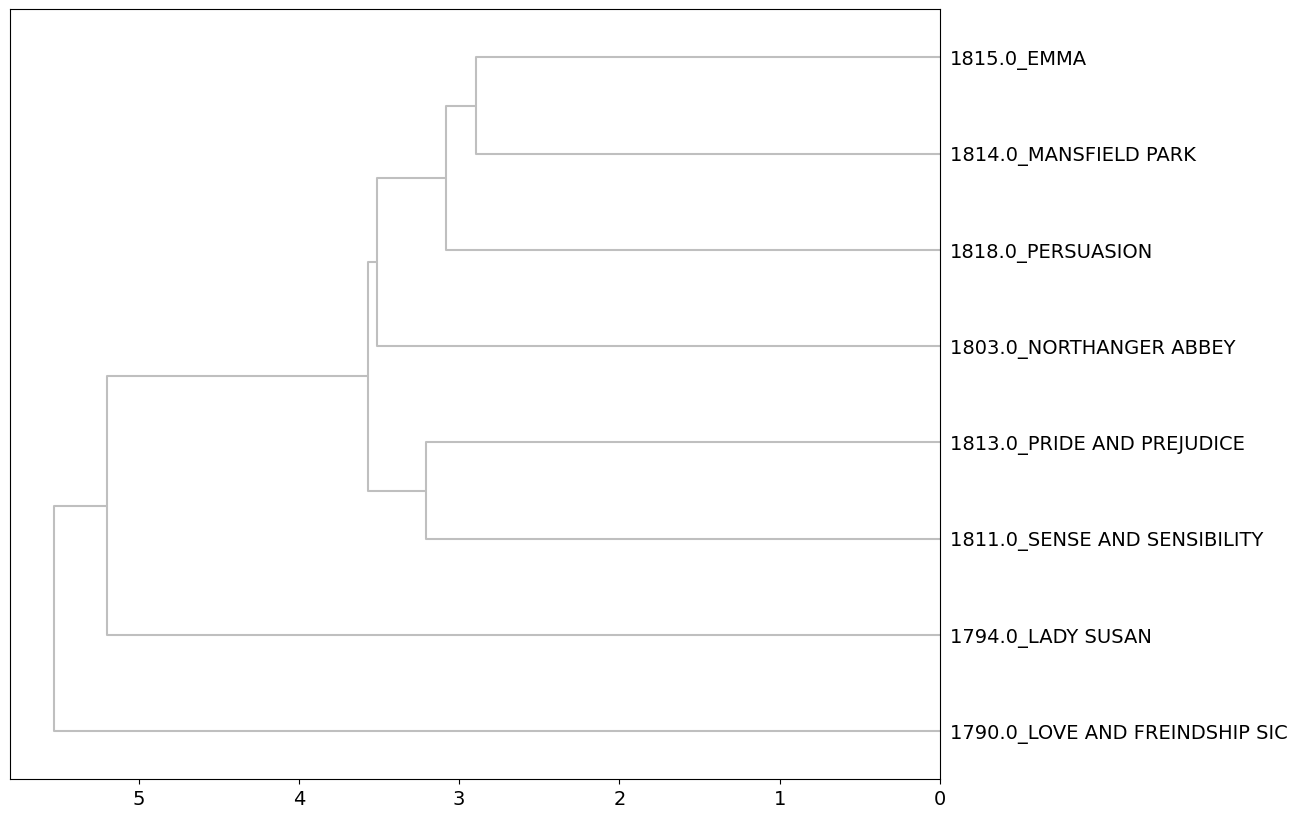

In [240]:
hac(PAIRS.cityblock, linkage_method='weighted', color_thresh=1.2)

<Figure size 640x480 with 0 Axes>

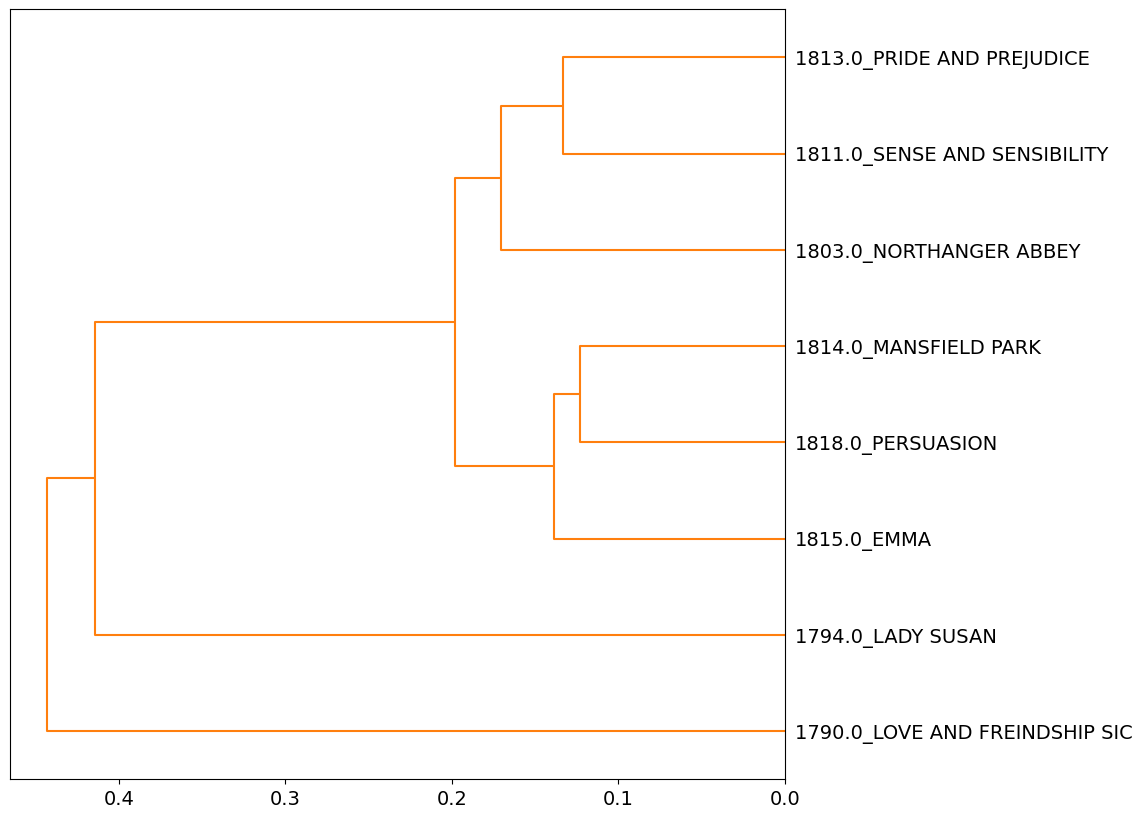

In [233]:
hac(PAIRS.cosine, linkage_method='ward', color_thresh=.85);

<Figure size 640x480 with 0 Axes>

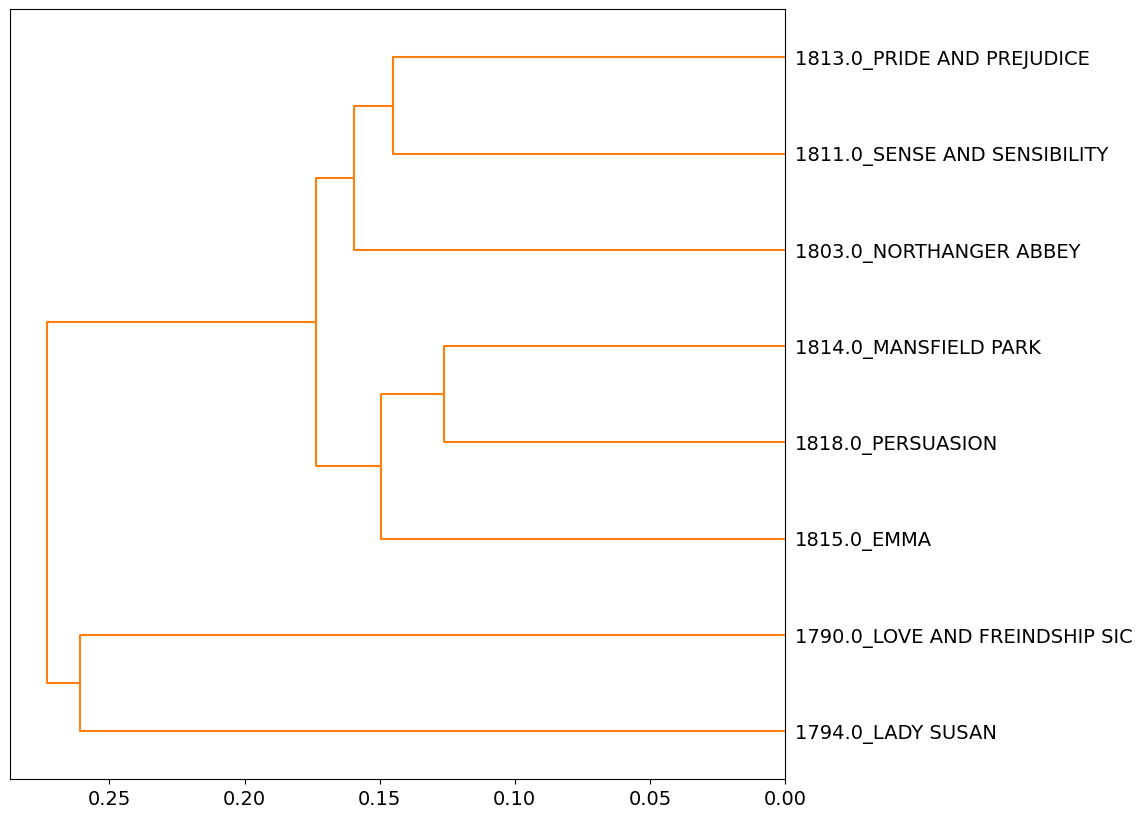

In [242]:
hac(PAIRS.euclidean, linkage_method='ward', color_thresh=.85);

<Figure size 640x480 with 0 Axes>

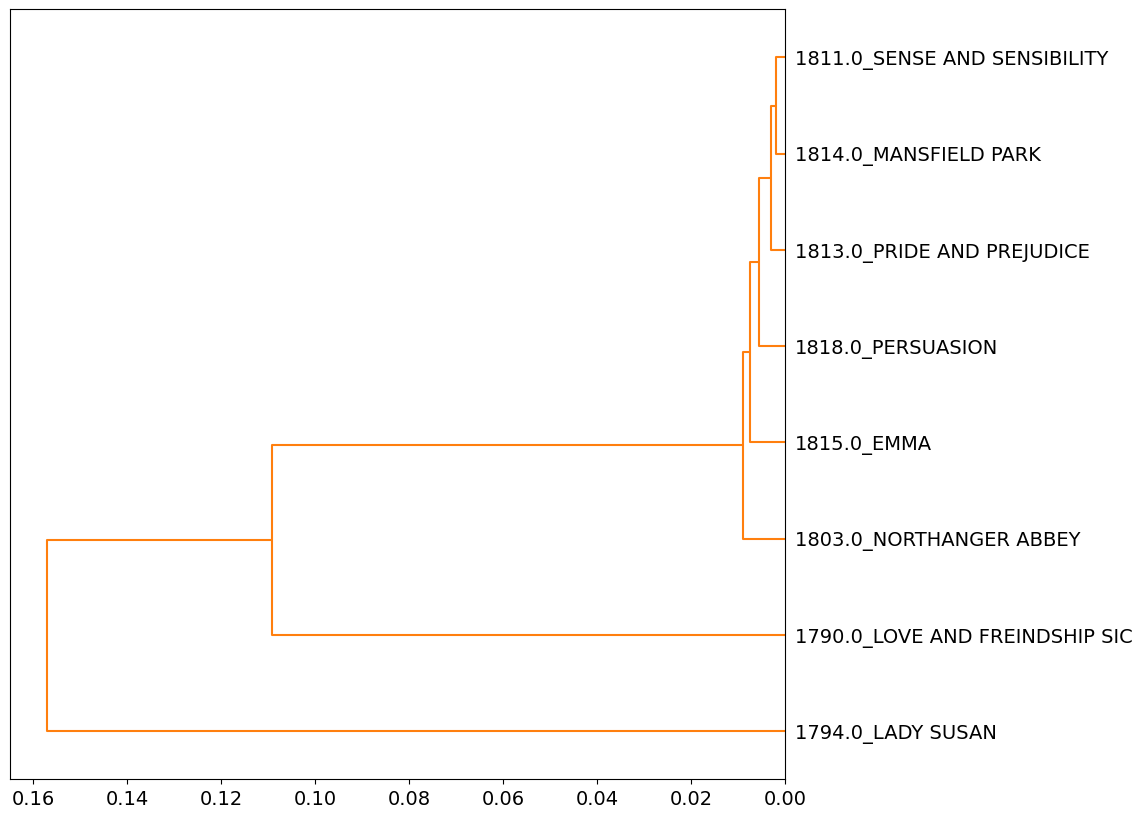

In [236]:
hac(PAIRS.jaccard, linkage_method='weighted', color_thresh=.85);

<Figure size 640x480 with 0 Axes>

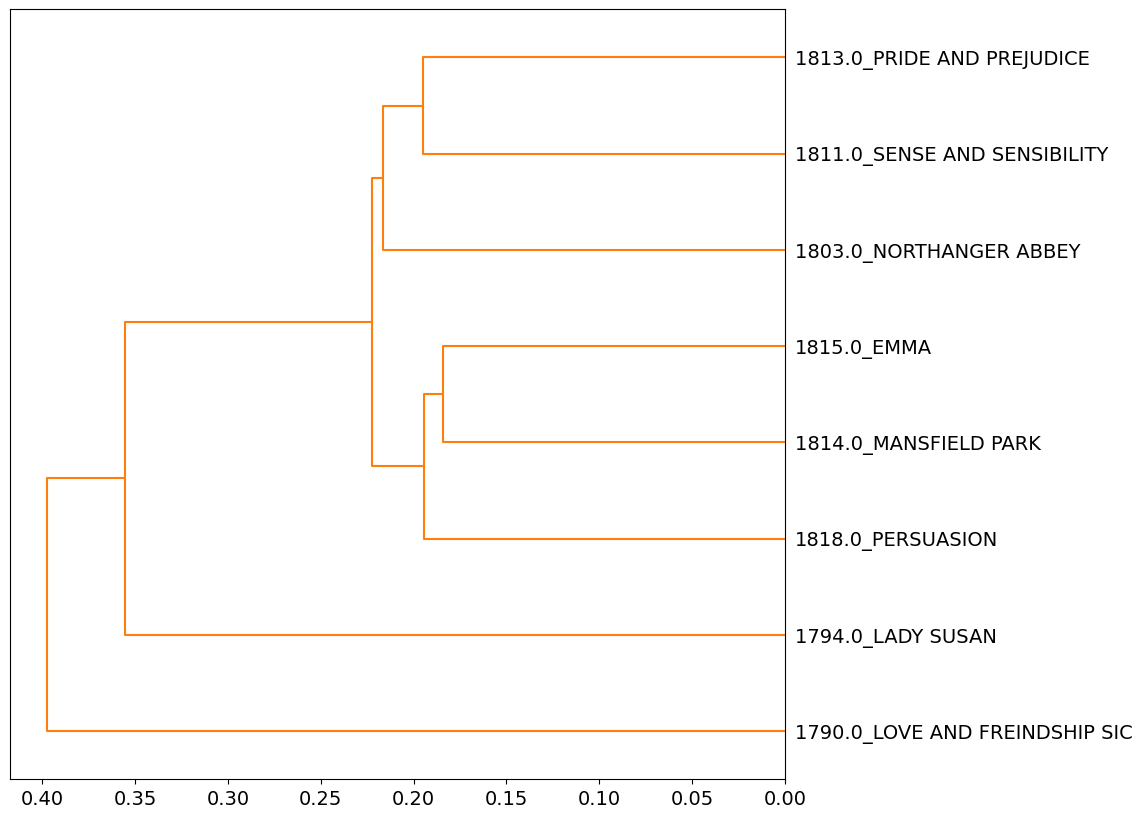

In [238]:
hac(PAIRS.js, linkage_method='weighted', color_thresh=.85);

### 1. What are the top 10 nouns by DFIDF, sorted in descending order? Include plural nouns, but don't include proper nouns. 

In [205]:
VOCAB.query("max_pos == 'NN' or max_pos == 'NNS'").join(DFIDF).sort_values('DFIDF', ascending=False).head(10)['DFIDF'].to_frame()

,DFIDF
term_str,
respect,177.266344
marriage,177.261968
fortune,177.261968
question,177.258990
ladies,177.258990
behaviour,177.240001
farther,177.240001
advantage,177.217644
girl,177.209470


### 2. Grouping your TFIDF results by book, and taking the mean TFIDF of all terms per book, what is Austen's most "significant" book? This value is computed from the TFIDF matrix your function returned.

In [218]:
TFIDF_means = TFIDF.loc[:, VOCAB.join(DFIDF, how='right').reset_index()['term_str'].to_list()]\
    .reset_index().groupby(['book_id']).mean().drop('chap_id', axis=1)

TFIDF_means.T.mean().to_frame('TFIDF').join(LIB, how='left').sort_values(by='TFIDF', ascending=False).head(1)[['title', 'TFIDF']]

,title,TFIDF
book_id,,
121,NORTHANGER ABBEY,0.001851


### 3. Using the dendograms you generated, which distance measure most clearly distinguishes Austen's two youthful works from her later works? That is, which measure show the greatest separation between the first two work and the rest? Note that the two youthful works were published before 1800.

<Figure size 640x480 with 0 Axes>

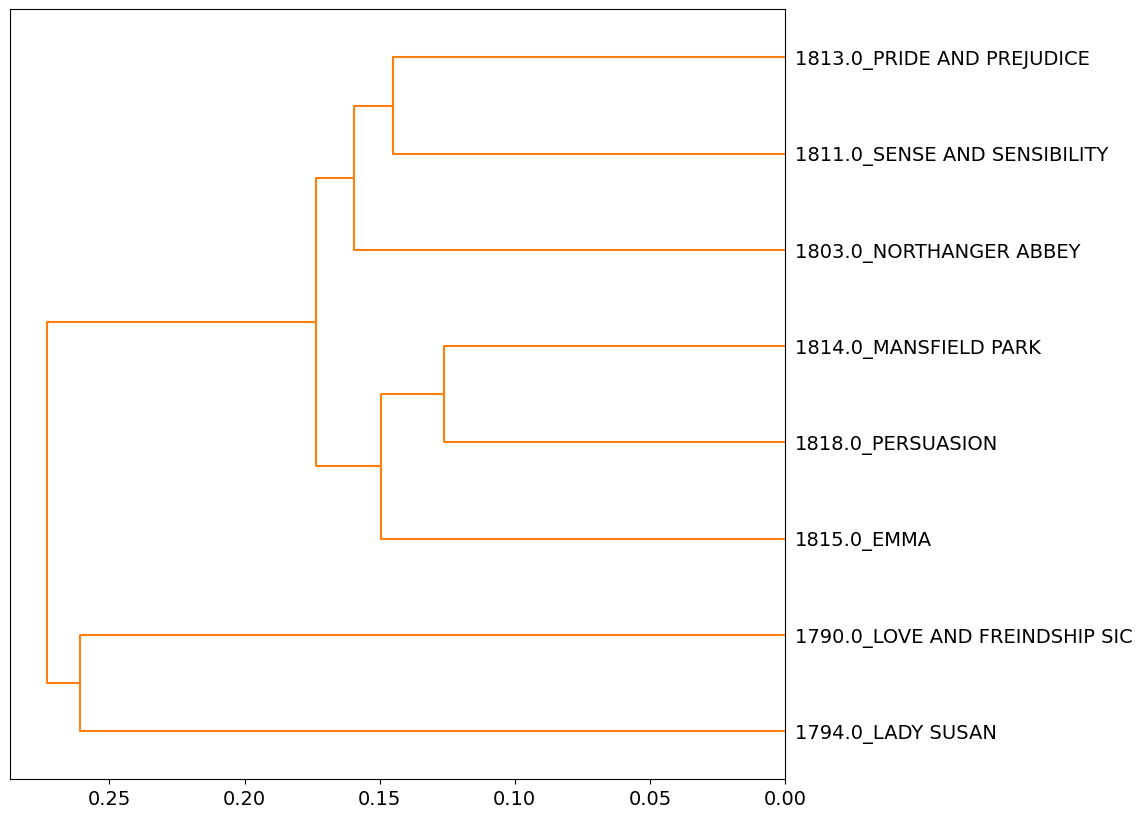

In [243]:
hac(PAIRS.euclidean, linkage_method='ward', color_thresh=.85);

As we can see from the dendrograms created, Austen's earliest works Lady Susan (946) and Love and Friendship (1212) are most clearly distinguished from her later works through **Euclidean** distance. Shown above, we can see the first split separates the two earliest works from the rest of Austen's works.

### 4. Do any of the distance measures produce dendrograms with works sorted in the exact order of their publication years? 

No, none of the dendrograms with the given distance and linkage measure combinations produce the works exactly sorted. However, **cityblock** comes the closest to doing so.

### 5. Some literary critics believe that Northanger Abbey is, among Austen's mature works, the one that most resembles her juvenalia, i.e. her two works written as a young adult. Which distance measure dendrograms appear to corroborate this thesis? In other words, do any of them show that Northanger Abbey is closer to her juvenalia than the her other adult works?

<Figure size 640x480 with 0 Axes>

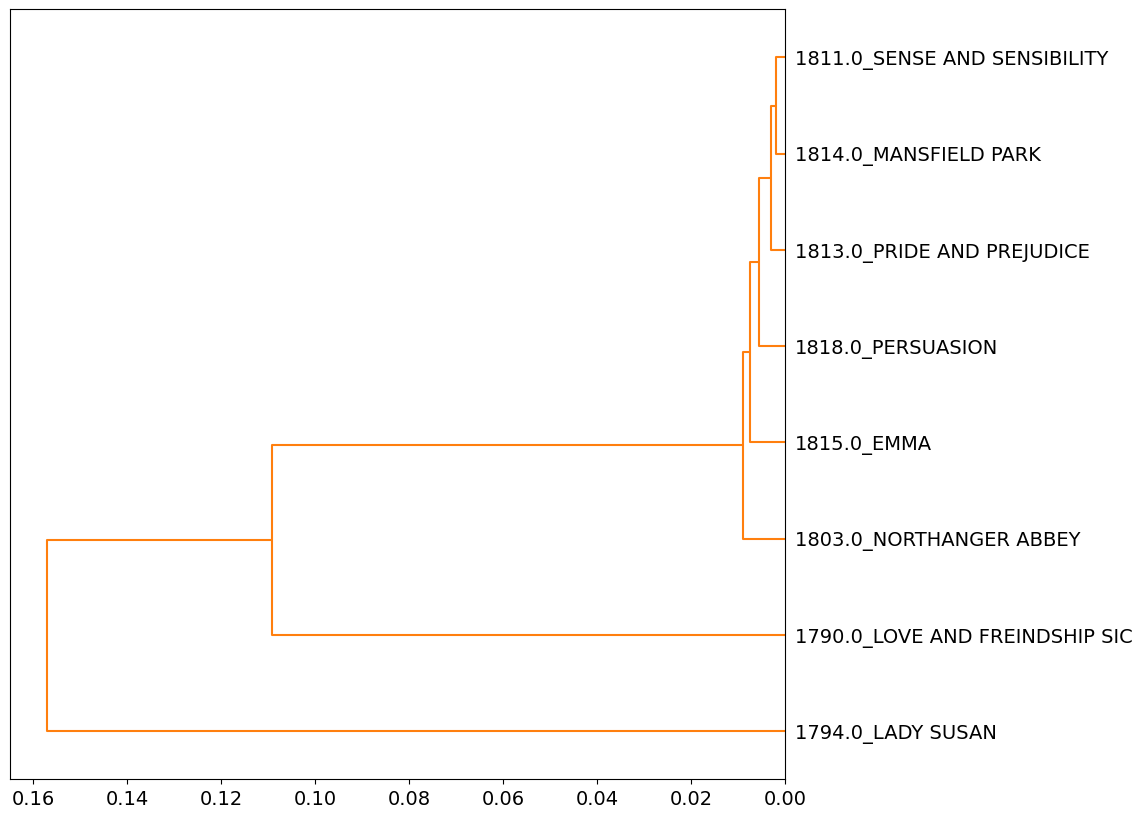

In [244]:
hac(PAIRS.jaccard, linkage_method='weighted', color_thresh=.85);

yes, the **jaccard** distance measure dendrogram shows that Northanger Abbey is closest to Austen's two earliest works!